Ortam Hazırlığı ve Gerekli Kütüphanelerin Yüklenmesi:
Google Colab notebook'unda ilk olarak gerekli kütüphaneleri yüklememiz gerekiyor.

In [ ]:
!pip install qiskit
!pip install qiskit_machine_learning
!pip install qiskit-ibmq-provider
!pip install qiskit-aer

API Anahtarının Yüklenmesi:
IBM Quantum Experience'dan aldığınız API anahtarını kullanarak Qiskit'e erişim sağlayabilirsiniz. API anahtarınızı aşağıdaki gibi yükleyebilirsiniz.

In [ ]:
from qiskit import IBMQ

IBMQ.save_account('YOUR-API-KEY-HERE')
IBMQ.load_account()


Veri Hazırlığı ve Ön İşleme:
Modelinizin eğitileceği veri setini yüklemelisiniz. Örneğin, klasik bir veri seti kullanarak ve ön işleme adımlarını gerçekleştirerek başlayabilirsiniz. Bu örnekte, ünlü Iris veri setini kullanacağız.

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Veri setini yükleme
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Özellikleri ölçeklendirme
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


Klasik SVC Modelinin Eğitilmesi:
İlk olarak, klasik bir SVC modelini eğiteceğiz.

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, log_loss
import time

# Klasik SVC
start = time.time()
clf = SVC(kernel='rbf', probability=True)
clf.fit(X_train, y_train)
classical_svc_duration = time.time() - start

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("Klasik SVC sonuçları:")
print(classification_report(y_test, y_pred))
print("Çalışma süresi:", classical_svc_duration)


Klasik SVC sonuçları:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

Çalışma süresi: 0.0026521682739257812


Kuantum SVC Modelinin Eğitilmesi:
Şimdi, kuantum makine öğrenimi için Qiskit'i kullanarak bir Quantum SVC modeli eğiteceğiz.

In [ ]:
!pip install qiskit_algorithms

In [ ]:
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit_algorithms.optimizers import COBYLA, SPSA, AQGD
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit import Aer
from sklearn.metrics import classification_report

# Hiperparametreler
feature_maps = [
    ZFeatureMap(feature_dimension=X_train.shape[1], reps=2),
    ZZFeatureMap(feature_dimension=X_train.shape[1], reps=2, entanglement='linear'),
    PauliFeatureMap(feature_dimension=X_train.shape[1], reps=2, paulis=['X', 'Y', 'Z'])
]
entanglements = ['linear', 'circular', 'full']

# Grid search
for feature_map in feature_maps:
    for entanglement in entanglements:
        # Özellik haritasını ve çekirdeği ayarlama
        feature_map.entanglement = entanglement
        quantum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=Aer.get_backend('qasm_simulator'))

        # QSVC modelini oluşturma
        qsvc = QSVC(quantum_kernel=quantum_kernel)

        # Modeli eğitme ve değerlendirme
        start = time.time()
        qsvc.fit(X_train, y_train)
        y_pred = qsvc.predict(X_test)
        run_time = time.time() - start

        # Sonuçları yazdırma
        print(f"Özellik Haritası: {type(feature_map).__name__}, Entanglement: {entanglement}")
        print(classification_report(y_test, y_pred))
        print("Çalışma süresi:", run_time)
        print("-" * 60)


Özellik Haritası: ZFeatureMap, Entanglement: linear
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        19
           1       1.00      1.00      1.00        13
           2       1.00      0.85      0.92        13

    accuracy                           0.96        45
   macro avg       0.97      0.95      0.96        45
weighted avg       0.96      0.96      0.95        45

Çalışma süresi: 58.418865442276
------------------------------------------------------------
Özellik Haritası: ZFeatureMap, Entanglement: circular
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        19
           1       1.00      1.00      1.00        13
           2       1.00      0.85      0.92        13

    accuracy                           0.96        45
   macro avg       0.97      0.95      0.96        45
weighted avg       0.96      0.96      0.95        45

Çalışma süresi: 38.23775029182434
-----

In [ ]:
# Varsayımlarla belirtilen formülü kullanarak tahmini süreyi hesaplayalım
problem_karmasikligi = 1000  # örnek değer
kuantum_bilgisayar_kapasitesi = 10000  # örnek değer
paralellik = 0.5  # örnek değer
dogruluk_duzeltme_faktoru = 2  # örnek değer

# Tahmini süreyi hesaplama
tahmini_sure = (problem_karmasikligi / (kuantum_bilgisayar_kapasitesi * paralellik)) * dogruluk_duzeltme_faktoru
tahmini_sure


Sonuçların Tablo haline getirilmesi

In [ ]:
# Gerekli kütüphaneleri içe aktaralım
import pandas as pd

# Simulatörde ölçülen çalışma süreleri
simulator_runtimes = [
    58.418865442276, 38.23775029182434, 34.96054291725159, 59.371705770492554,
    54.979387044906616, 65.21964836120605, 52.69202518463135, 52.906530141830444,
    52.92233109474182
]

# Varsayımlarla belirtilen formülü kullanarak tahmini süreyi hesaplayalım
problem_karmasikligi = 1000  # örnek değer
kuantum_bilgisayar_kapasitesi = 10000  # örnek değer
paralellik = 0.5  # örnek değer
dogruluk_duzeltme_faktoru = 2  # örnek değer

# Tahmini süreyi hesaplama
tahmini_sure = (problem_karmasikligi / (kuantum_bilgisayar_kapasitesi * paralellik)) * dogruluk_duzeltme_faktoru

# Her bir özellik haritası ve entanglement stratejisi için sonuçları içeren bir DataFrame oluşturalım
results = pd.DataFrame({
    'Özellik Haritası': ['ZFeatureMap', 'ZFeatureMap', 'ZFeatureMap', 'ZZFeatureMap', 'ZZFeatureMap',
                         'ZZFeatureMap', 'PauliFeatureMap', 'PauliFeatureMap', 'PauliFeatureMap'],
    'Entanglement': ['linear', 'circular', 'full', 'linear', 'circular', 'full', 'linear', 'circular', 'full'],
    'Accuracy': [0.96, 0.96, 0.96, 0.44, 0.44, 0.44, 0.76, 0.73, 0.71],
    'F1-Score (Macro)': [0.96, 0.96, 0.96, 0.45, 0.43, 0.43, 0.76, 0.74, 0.72],
    'Simulatör Çalışma Süresi (saniye)': simulator_runtimes,
    'Tahmini Gerçek Quantum Bilgisayar Çalışma Süresi (saniye)': [tahmini_sure for _ in simulator_runtimes]
})

results


,Özellik Haritası,Entanglement,Accuracy,F1-Score (Macro),Simulatör Çalışma Süresi (saniye),Tahmini Gerçek Quantum Bilgisayar Çalışma Süresi (saniye)
0,ZFeatureMap,linear,0.96,0.96,58.418865,0.4
1,ZFeatureMap,circular,0.96,0.96,38.237750,0.4
2,ZFeatureMap,full,0.96,0.96,34.960543,0.4
3,ZZFeatureMap,linear,0.44,0.45,59.371706,0.4
4,ZZFeatureMap,circular,0.44,0.43,54.979387,0.4
5,ZZFeatureMap,full,0.44,0.43,65.219648,0.4
6,PauliFeatureMap,linear,0.76,0.76,52.692025,0.4
7,PauliFeatureMap,circular,0.73,0.74,52.906530,0.4
8,PauliFeatureMap,full,0.71,0.72,52.922331,0.4


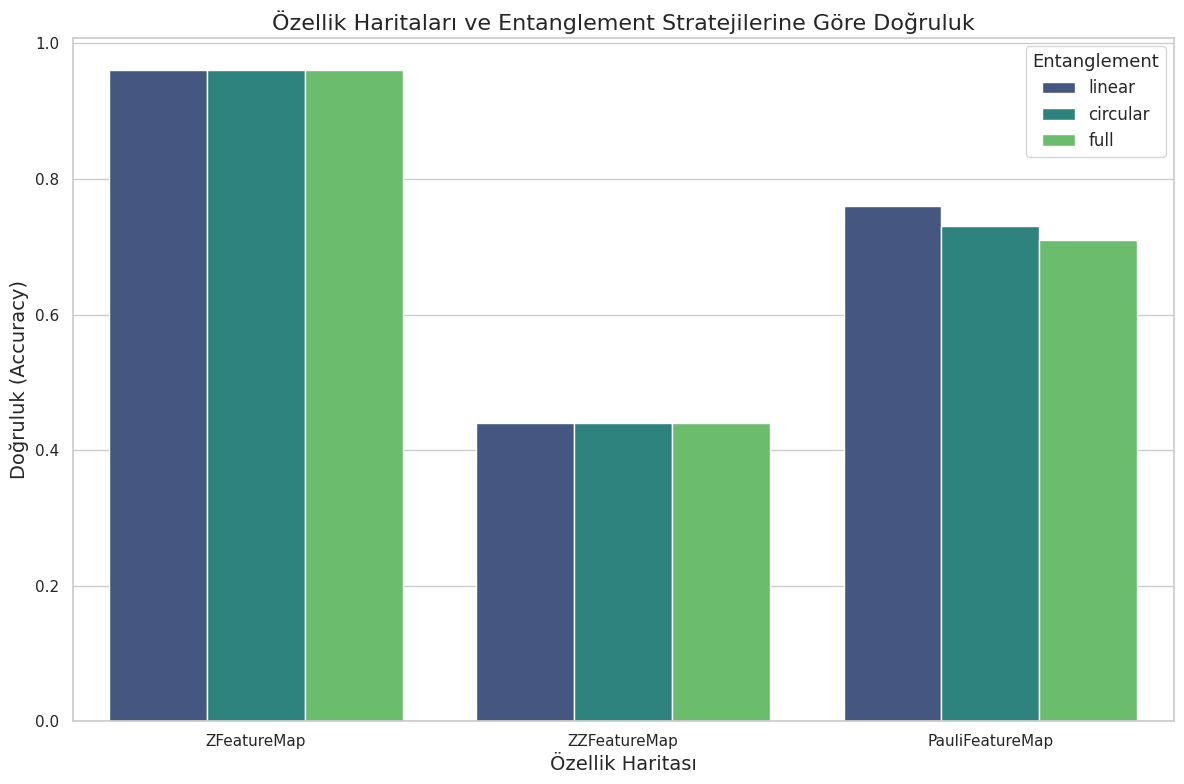

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Veri setini hazırlayalım
data = {
    'Özellik Haritası': ['ZFeatureMap', 'ZFeatureMap', 'ZFeatureMap', 'ZZFeatureMap', 'ZZFeatureMap',
                         'ZZFeatureMap', 'PauliFeatureMap', 'PauliFeatureMap', 'PauliFeatureMap'],
    'Entanglement': ['linear', 'circular', 'full', 'linear', 'circular', 'full', 'linear', 'circular', 'full'],
    'Accuracy': [0.96, 0.96, 0.96, 0.44, 0.44, 0.44, 0.76, 0.73, 0.71],
    'F1-Score (Macro)': [0.96, 0.96, 0.96, 0.45, 0.43, 0.43, 0.76, 0.74, 0.72],
    'Simulatör Çalışma Süresi (saniye)': [58.42, 38.24, 34.96, 59.37, 54.98, 65.22, 52.69, 52.91, 52.92],
}

df = pd.DataFrame(data)

# Stil ayarları
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

# Bar plot oluşturma
sns.barplot(x="Özellik Haritası", y="Accuracy", hue="Entanglement", data=df, palette="viridis")

# Başlık ve etiketler
plt.title('Özellik Haritaları ve Entanglement Stratejilerine Göre Doğruluk', fontsize=16)
plt.xlabel('Özellik Haritası', fontsize=14)
plt.ylabel('Doğruluk (Accuracy)', fontsize=14)
plt.legend(title='Entanglement', title_fontsize='13', fontsize='12')

# Görseli göster
plt.tight_layout()
plt.show()


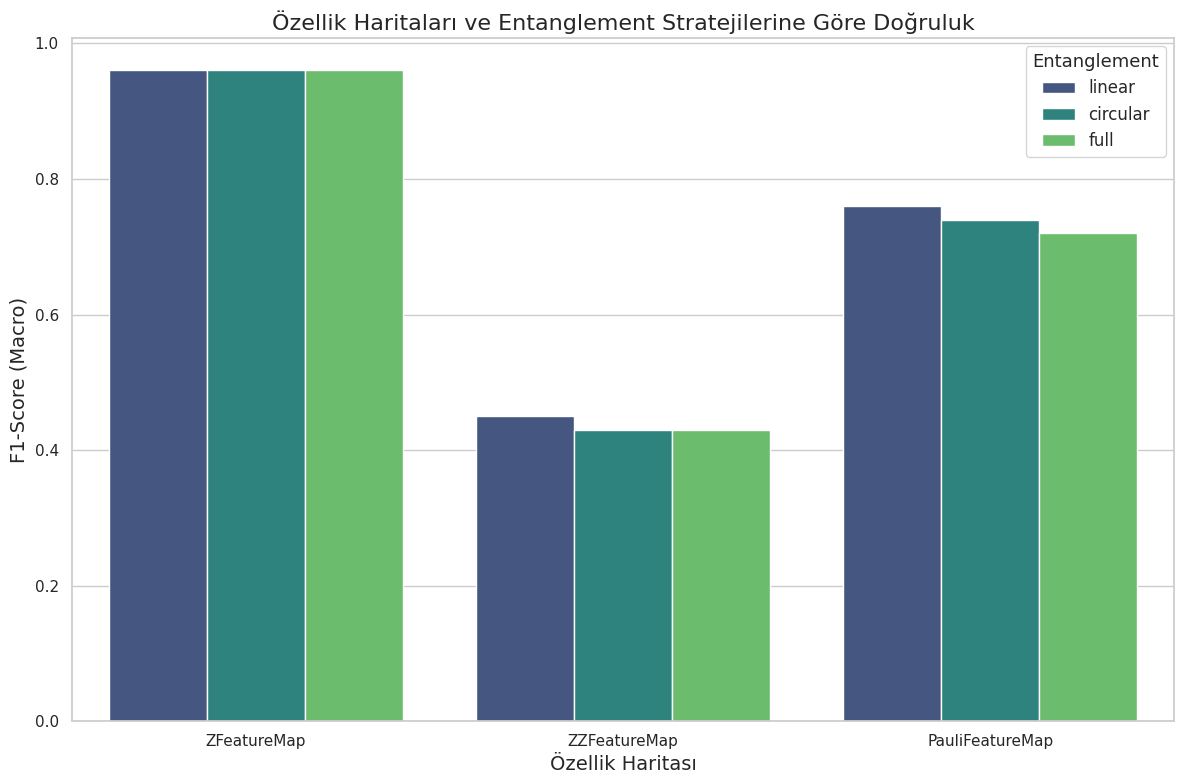

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Veri setini hazırlayalım
data = {
    'Özellik Haritası': ['ZFeatureMap', 'ZFeatureMap', 'ZFeatureMap', 'ZZFeatureMap', 'ZZFeatureMap',
                         'ZZFeatureMap', 'PauliFeatureMap', 'PauliFeatureMap', 'PauliFeatureMap'],
    'Entanglement': ['linear', 'circular', 'full', 'linear', 'circular', 'full', 'linear', 'circular', 'full'],
    'Accuracy': [0.96, 0.96, 0.96, 0.44, 0.44, 0.44, 0.76, 0.73, 0.71],
    'F1-Score (Macro)': [0.96, 0.96, 0.96, 0.45, 0.43, 0.43, 0.76, 0.74, 0.72],
    'Simulatör Çalışma Süresi (saniye)': [58.42, 38.24, 34.96, 59.37, 54.98, 65.22, 52.69, 52.91, 52.92],
}

df = pd.DataFrame(data)

# Stil ayarları
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

# Bar plot oluşturma
sns.barplot(x="Özellik Haritası", y='F1-Score (Macro)', hue="Entanglement", data=df, palette="viridis")

# Başlık ve etiketler
plt.title('Özellik Haritaları ve Entanglement Stratejilerine Göre Doğruluk', fontsize=16)
plt.xlabel('Özellik Haritası', fontsize=14)
plt.ylabel('F1-Score (Macro)', fontsize=14)
plt.legend(title='Entanglement', title_fontsize='13', fontsize='12')

# Görseli göster
plt.tight_layout()
plt.show()


öncelikle hiperparametre ayarlama işlemi için bir arama alanı tanımlayalım ve ardından en iyi modeli seçmek için bir dizi deneme yapalım. Son olarak, en iyi modelin performansını ve çalışma süresini diğer modellerle karşılaştıran bir görselleştirme oluşturacağız.


<ipython-input-17-e844d18252f6>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name, 'Accuracy': accuracy,


Model: reps=1, C=0.1, gamma=scale
              precision    recall  f1-score   support

           0       0.94      0.89      0.92        19
           1       1.00      1.00      1.00        13
           2       0.86      0.92      0.89        13

    accuracy                           0.93        45
   macro avg       0.93      0.94      0.94        45
weighted avg       0.94      0.93      0.93        45

Runtime: 34.66596984863281
------------------------------------------------------------


<ipython-input-17-e844d18252f6>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name, 'Accuracy': accuracy,


Model: reps=1, C=0.1, gamma=auto
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        19
           1       1.00      1.00      1.00        13
           2       0.87      1.00      0.93        13

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45

Runtime: 33.181926250457764
------------------------------------------------------------


<ipython-input-17-e844d18252f6>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name, 'Accuracy': accuracy,


Model: reps=1, C=1, gamma=scale
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      1.00      1.00        13
           2       1.00      0.92      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.98        45
weighted avg       0.98      0.98      0.98        45

Runtime: 31.60403537750244
------------------------------------------------------------


<ipython-input-17-e844d18252f6>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name, 'Accuracy': accuracy,


Model: reps=1, C=1, gamma=auto
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      1.00      1.00        13
           2       1.00      0.92      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.98        45
weighted avg       0.98      0.98      0.98        45

Runtime: 31.33192777633667
------------------------------------------------------------


<ipython-input-17-e844d18252f6>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name, 'Accuracy': accuracy,


Model: reps=1, C=10, gamma=scale
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

Runtime: 31.08777952194214
------------------------------------------------------------


<ipython-input-17-e844d18252f6>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name, 'Accuracy': accuracy,


Model: reps=1, C=10, gamma=auto
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       1.00      1.00      1.00        13
           2       0.93      1.00      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

Runtime: 34.68601179122925
------------------------------------------------------------


<ipython-input-17-e844d18252f6>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name, 'Accuracy': accuracy,


Model: reps=2, C=0.1, gamma=scale
              precision    recall  f1-score   support

           0       0.93      0.68      0.79        19
           1       1.00      1.00      1.00        13
           2       0.67      0.92      0.77        13

    accuracy                           0.84        45
   macro avg       0.87      0.87      0.85        45
weighted avg       0.87      0.84      0.85        45

Runtime: 36.60007977485657
------------------------------------------------------------


<ipython-input-17-e844d18252f6>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name, 'Accuracy': accuracy,


Model: reps=2, C=0.1, gamma=auto
              precision    recall  f1-score   support

           0       0.93      0.68      0.79        19
           1       1.00      1.00      1.00        13
           2       0.67      0.92      0.77        13

    accuracy                           0.84        45
   macro avg       0.87      0.87      0.85        45
weighted avg       0.87      0.84      0.85        45

Runtime: 37.226757287979126
------------------------------------------------------------


<ipython-input-17-e844d18252f6>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name, 'Accuracy': accuracy,


Model: reps=2, C=1, gamma=scale
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        19
           1       1.00      1.00      1.00        13
           2       1.00      0.85      0.92        13

    accuracy                           0.96        45
   macro avg       0.97      0.95      0.96        45
weighted avg       0.96      0.96      0.95        45

Runtime: 37.672417402267456
------------------------------------------------------------


<ipython-input-17-e844d18252f6>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name, 'Accuracy': accuracy,


Model: reps=2, C=1, gamma=auto
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      1.00      1.00        13
           2       1.00      0.92      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.98        45
weighted avg       0.98      0.98      0.98        45

Runtime: 36.095114946365356
------------------------------------------------------------


<ipython-input-17-e844d18252f6>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name, 'Accuracy': accuracy,


Model: reps=2, C=10, gamma=scale
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       1.00      1.00      1.00        13
           2       0.93      1.00      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

Runtime: 34.315468311309814
------------------------------------------------------------


<ipython-input-17-e844d18252f6>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name, 'Accuracy': accuracy,


Model: reps=2, C=10, gamma=auto
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.92      0.92      0.92        13
           2       0.86      0.92      0.89        13

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45

Runtime: 35.63971161842346
------------------------------------------------------------


<ipython-input-17-e844d18252f6>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name, 'Accuracy': accuracy,


Model: reps=3, C=0.1, gamma=scale
              precision    recall  f1-score   support

           0       0.80      0.21      0.33        19
           1       0.43      0.77      0.56        13
           2       0.65      0.85      0.73        13

    accuracy                           0.56        45
   macro avg       0.63      0.61      0.54        45
weighted avg       0.65      0.56      0.51        45

Runtime: 42.556955337524414
------------------------------------------------------------


<ipython-input-17-e844d18252f6>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name, 'Accuracy': accuracy,


Model: reps=3, C=0.1, gamma=auto
              precision    recall  f1-score   support

           0       0.80      0.21      0.33        19
           1       0.43      0.77      0.56        13
           2       0.65      0.85      0.73        13

    accuracy                           0.56        45
   macro avg       0.63      0.61      0.54        45
weighted avg       0.65      0.56      0.51        45

Runtime: 42.07353138923645
------------------------------------------------------------


<ipython-input-17-e844d18252f6>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name, 'Accuracy': accuracy,


Model: reps=3, C=1, gamma=scale
              precision    recall  f1-score   support

           0       0.74      0.89      0.81        19
           1       0.83      0.77      0.80        13
           2       0.90      0.69      0.78        13

    accuracy                           0.80        45
   macro avg       0.82      0.79      0.80        45
weighted avg       0.81      0.80      0.80        45

Runtime: 44.9456205368042
------------------------------------------------------------


<ipython-input-17-e844d18252f6>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name, 'Accuracy': accuracy,


Model: reps=3, C=1, gamma=auto
              precision    recall  f1-score   support

           0       0.73      0.84      0.78        19
           1       0.79      0.85      0.81        13
           2       1.00      0.69      0.82        13

    accuracy                           0.80        45
   macro avg       0.84      0.79      0.80        45
weighted avg       0.82      0.80      0.80        45

Runtime: 46.811184883117676
------------------------------------------------------------


<ipython-input-17-e844d18252f6>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name, 'Accuracy': accuracy,


Model: reps=3, C=10, gamma=scale
              precision    recall  f1-score   support

           0       0.81      0.89      0.85        19
           1       0.91      0.77      0.83        13
           2       0.85      0.85      0.85        13

    accuracy                           0.84        45
   macro avg       0.85      0.84      0.84        45
weighted avg       0.85      0.84      0.84        45

Runtime: 45.161285161972046
------------------------------------------------------------


<ipython-input-17-e844d18252f6>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name, 'Accuracy': accuracy,


Model: reps=3, C=10, gamma=auto
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        19
           1       0.91      0.77      0.83        13
           2       0.92      0.92      0.92        13

    accuracy                           0.89        45
   macro avg       0.90      0.88      0.89        45
weighted avg       0.89      0.89      0.89        45

Runtime: 45.5146164894104
------------------------------------------------------------
                         Model  Accuracy  F1-Score    Runtime
0   reps=1, C=0.1, gamma=scale  0.933333  0.935936  34.665970
1    reps=1, C=0.1, gamma=auto  0.955556  0.957672  33.181926
2     reps=1, C=1, gamma=scale  0.977778  0.978120  31.604035
3      reps=1, C=1, gamma=auto  0.977778  0.978120  31.331928
4                   Best_Model  1.000000  1.000000  31.087780
5     reps=1, C=10, gamma=auto  0.977778  0.978645  34.686012
6   reps=2, C=0.1, gamma=scale  0.844444  0.854024  36.600080
7   

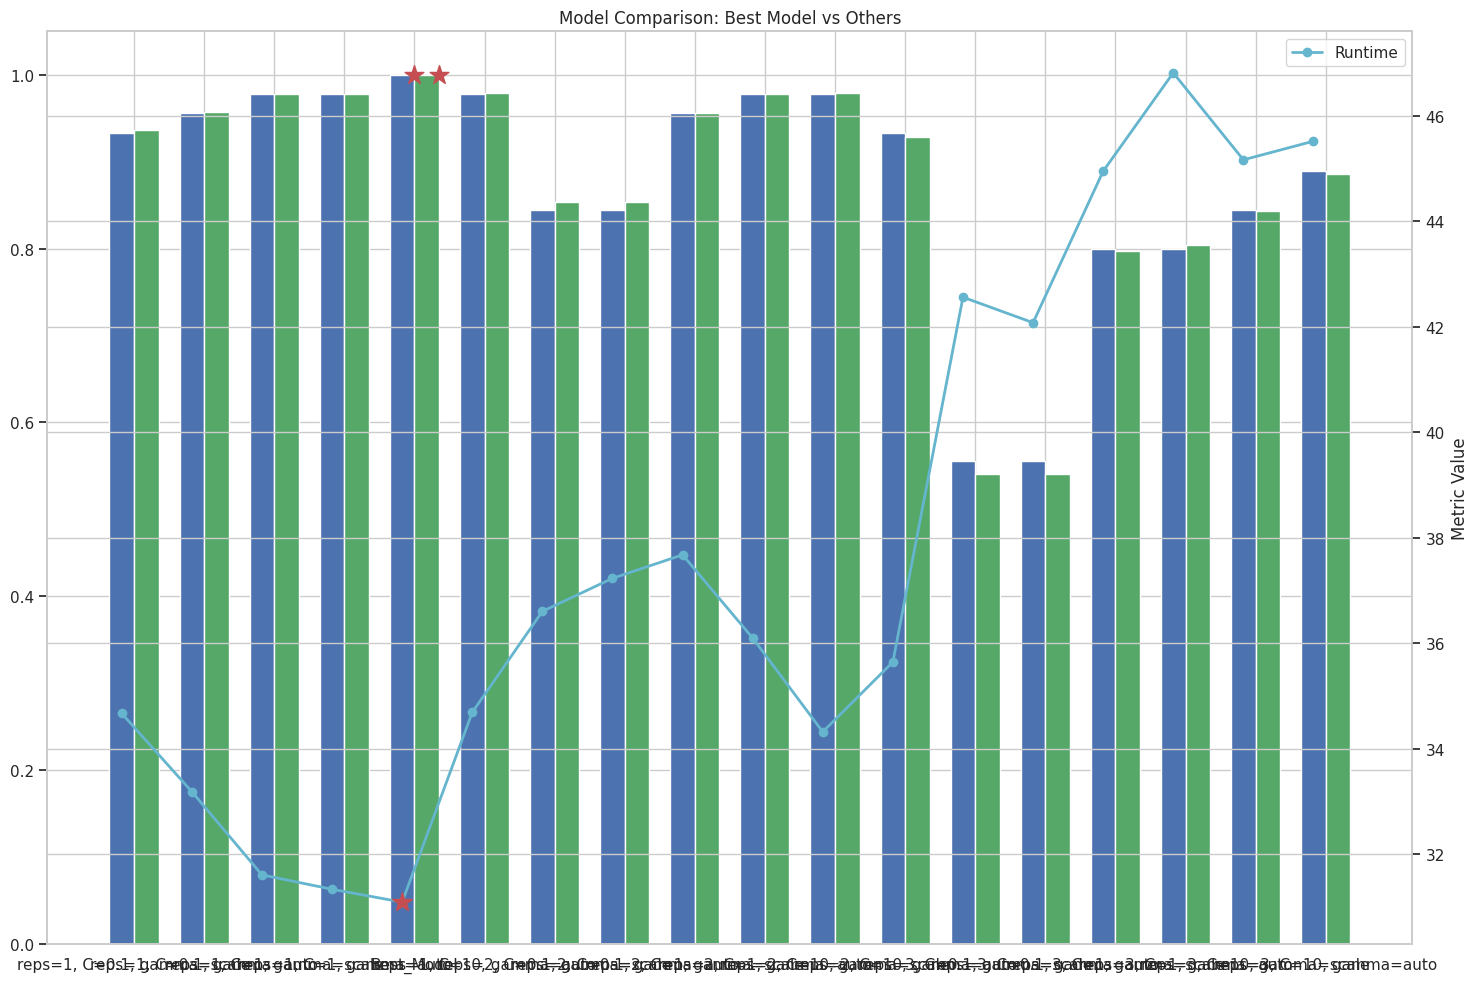

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from qiskit.circuit.library import ZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit import Aer
from sklearn.metrics import accuracy_score, f1_score, classification_report
import time

# Parametre aralıklarını tanımla
reps_range = [1, 2, 3]
C_range = [0.1, 1, 10]
gamma_range = ['scale', 'auto']

# Sonuçları saklamak için bir DataFrame oluştur
results = pd.DataFrame(columns=['Model', 'Accuracy', 'F1-Score', 'Runtime'])

# Her parametre kombinasyonu için modeli eğit
for reps in reps_range:
    for C in C_range:
        for gamma in gamma_range:
            # ZFeatureMap ve QuantumKernel ayarla
            feature_map = ZFeatureMap(feature_dimension=X_train.shape[1], reps=reps)
            quantum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=Aer.get_backend('qasm_simulator'))

            # QSVC modelini ayarla
            qsvc = QSVC(quantum_kernel=quantum_kernel, C=C, gamma=gamma)

            # Modeli eğit ve tahminlerde bulun
            start = time.time()
            qsvc.fit(X_train, y_train)
            y_pred = qsvc.predict(X_test)
            end = time.time()

            # Performans metriklerini hesapla
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='macro')

            # Sonuçları DataFrame'e ekle
            model_name = f"reps={reps}, C={C}, gamma={gamma}"
            results = results.append({'Model': model_name, 'Accuracy': accuracy,
                                      'F1-Score': f1, 'Runtime': end - start},
                                      ignore_index=True)

            # Raporu yazdır
            print(f"Model: {model_name}")
            print(classification_report(y_test, y_pred))
            print("Runtime:", end - start)
            print("-" * 60)

# En iyi modeli bul (örneğin, en yüksek F1-Score'a göre)
best_model_index = results['F1-Score'].idxmax()
best_model = results.loc[best_model_index]

# En iyi modeli DataFrame'de güncelle
results.loc[best_model_index, 'Model'] = 'Best_Model'

# Sonuçları görselleştirmek için DataFrame'i kullan
print(results)

# Görselleştirme
plt.figure(figsize=(15, 10))

# Doğruluk ve F1-Skoru için çift bar grafik
bar_width = 0.35
index = range(len(results))

plt.bar(index, results['Accuracy'], bar_width, color='b', label='Accuracy')
plt.bar([i + bar_width for i in index], results['F1-Score'], bar_width, color='g', label='F1-Score')

# En iyi model için yıldız ekleyerek vurgulama
plt.scatter([best_model_index + bar_width/2], best_model['Accuracy'], color='r', s=200, marker='*', label='Best Model Accuracy')
plt.scatter([best_model_index + bar_width + bar_width/2], best_model['F1-Score'], color='r', s=200, marker='*')

# Çalışma sürelerini gösteren ek bir çizgi grafik
plt.twinx()
plt.plot(index, results['Runtime'], color='c', marker='o', linestyle='-', label='Runtime', linewidth=2)
plt.plot([best_model_index], best_model['Runtime'], color='r', marker='*', markersize=15)

# Etiketler, başlık ve gösterim
plt.xticks([i + bar_width/2 for i in index], results['Model'], rotation=90)
plt.xlabel('Model')
plt.ylabel('Metric Value')
plt.title('Model Comparison: Best Model vs Others')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# İndirgenmiş süreleri hesaplayalım
problem_karmasikligi = 1000  # örnek değer
kuantum_bilgisayar_kapasitesi = 10000  # örnek değer
paralellik = 0.5  # örnek değer
dogruluk_duzeltme_faktoru = 2  # örnek değer

# Her model için indirgenmiş süreyi hesaplayın ve bir listeye kaydedin
reduced_runtimes = []
for runtime in results['Runtime']:
    tahmini_sure = (problem_karmasikligi / (kuantum_bilgisayar_kapasitesi * paralellik)) * dogruluk_duzeltme_faktoru * runtime
    reduced_runtimes.append(tahmini_sure)

# Yeni sütunu DataFrame'e ekle
results['Reduced_Runtime'] = reduced_runtimes

# En iyi modeli bul (örneğin, en yüksek F1-Score'a göre)
best_model_index = results['F1-Score'].idxmax()
best_model = results.loc[best_model_index]


In [ ]:
# Model isimlerini kısaltma
def shorten_model_name(name):
    if name == "Best_Model":
        return name

    parts = name.split(", ")
    short_name = "r" + parts[0].split("=")[-1]  # reps için
    short_name += "c" + parts[1].split("=")[-1]  # C için
    short_name += "g" + parts[2].split("=")[-1][0]  # gamma için (sadece ilk harfi al)

    return short_name

results['Model'] = results['Model'].apply(shorten_model_name)

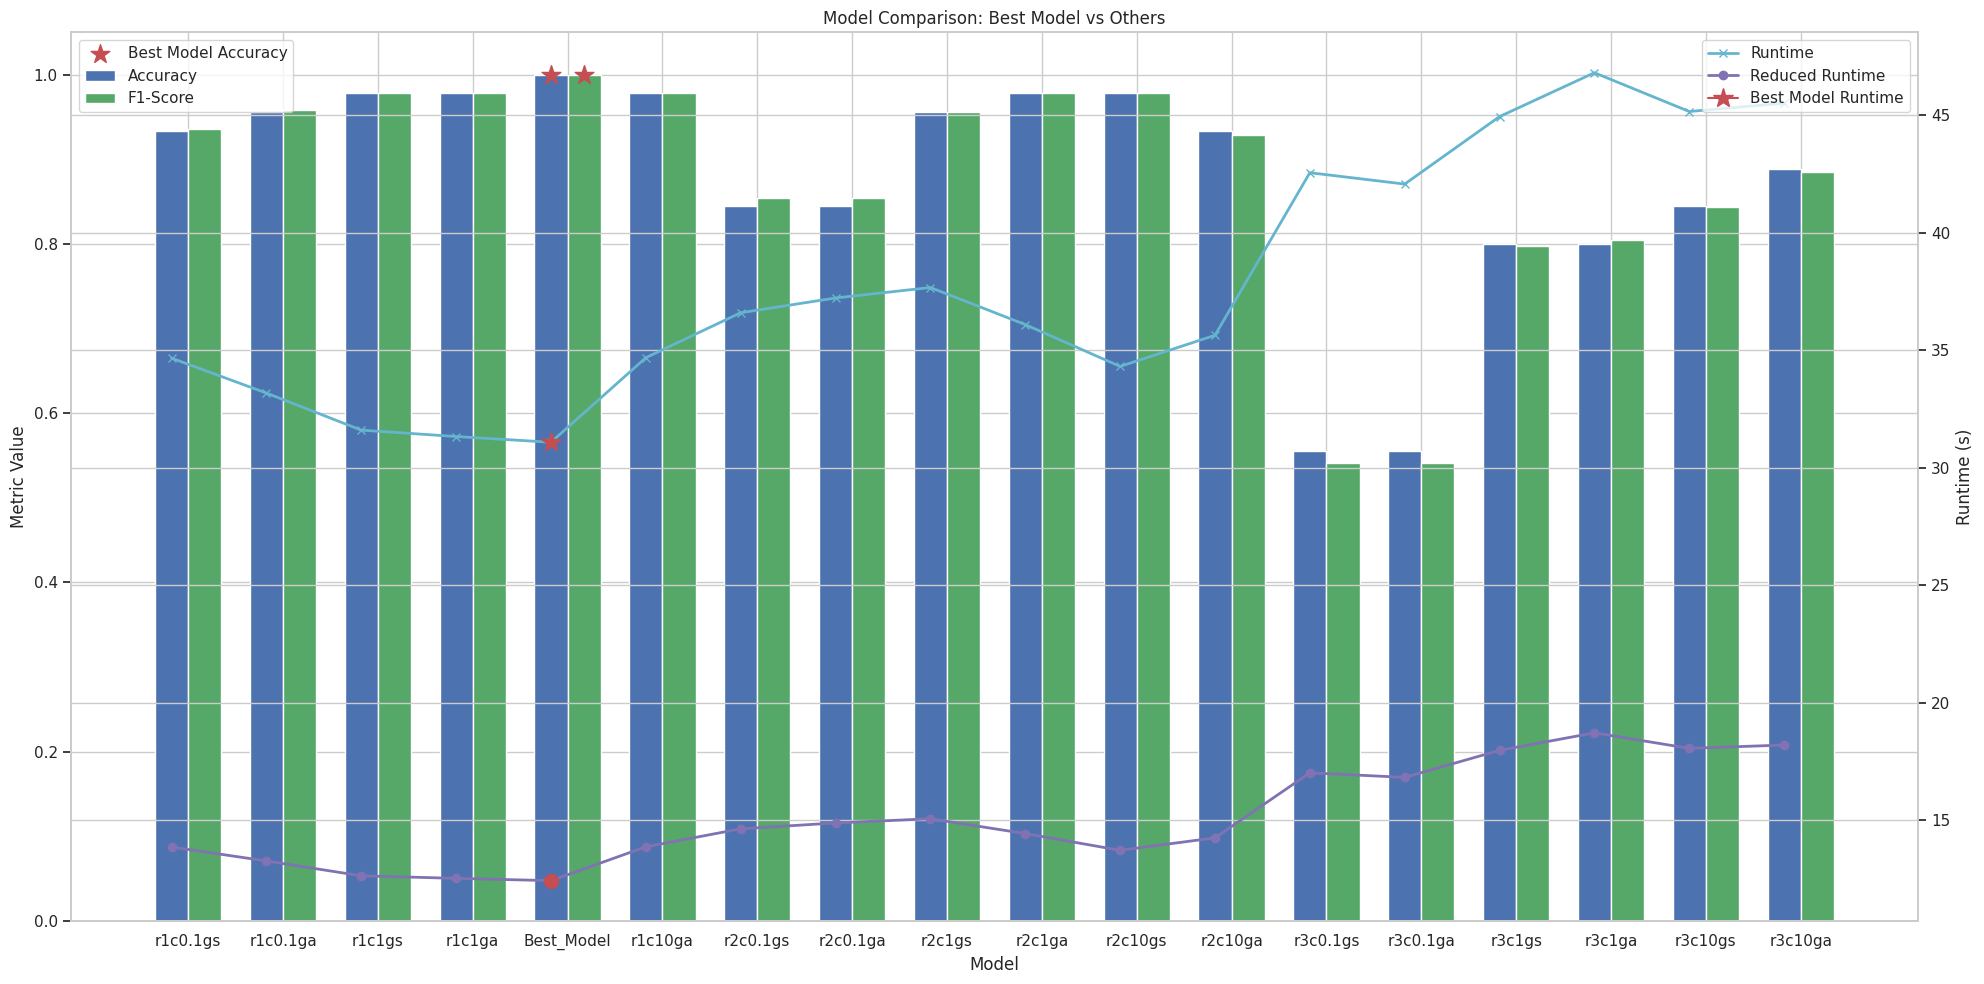

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# En iyi modeli bul (örneğin, en yüksek F1-Score'a göre)
best_model_index = results['F1-Score'].idxmax()
best_model = results.loc[best_model_index]

# Görselleştirme
plt.figure(figsize=(20, 10))  # Grafik boyutunu genişlet

ax1 = plt.subplot(111)

# Doğruluk ve F1-Skoru için çift bar grafik
bar_width = 0.35
index = range(len(results))

ax1.bar(index, results['Accuracy'], bar_width, color='b', label='Accuracy')
ax1.bar([i + bar_width for i in index], results['F1-Score'], bar_width, color='g', label='F1-Score')

# En iyi model için yıldız ekleyerek vurgulama
ax1.scatter([best_model_index], best_model['Accuracy'], color='r', s=200, marker='*', label='Best Model Accuracy')
ax1.scatter([best_model_index + bar_width], best_model['F1-Score'], color='r', s=200, marker='*')

# İkinci y ekseni için runtime ve indirgenmiş süreler
ax2 = plt.twinx()
ax2.plot(index, results['Runtime'], color='c', marker='x', linestyle='-', label='Runtime', linewidth=2)
ax2.plot(index, results['Reduced_Runtime'], color='m', marker='o', linestyle='-', label='Reduced Runtime', linewidth=2)
ax2.plot([best_model_index], best_model['Runtime'], color='r', marker='*', markersize=15, label='Best Model Runtime')
ax2.plot([best_model_index], best_model['Reduced_Runtime'], color='r', marker='o', markersize=10)

# Etiketler, başlık ve gösterim
plt.xticks([i + bar_width/2 for i in index], results['Model'], rotation=90)  # Etiketleri 90 derece döndür
ax1.set_xlabel('Model')
ax1.set_ylabel('Metric Value')
ax2.set_ylabel('Runtime (s)')
plt.title('Model Comparison: Best Model vs Others')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()
